In [ ]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-b8lygdd6
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-b8lygdd6
  Created wheel for pyFTS: filename=pyFTS-1.6-py3-none-any.whl size=217208 sha256=6f6a249cf18bc713723cacbba1c0d71b813cf7a6eb7751654056a02e3d317eb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-3t5lh9nc/wheels/30/23/2b/2e10c811e284f08e37b5f6d6320e78bade4dd580081288f61a
Successfully built pyFTS


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
import numpy as np
from math import e,sqrt

def step(x, deriv=False):
    if deriv:
        return np.abs(1 * (x == 0))
    else:
        return np.abs(1 * (x > 0))


def sigmoid(x, deriv=False):
    if deriv:
        #return sigmoid(x)*(1 - sigmoid(x))
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))


def softmax(x, deriv=False):
    if deriv:
        pass
    else:
        mvs = sum([np.exp(k) for k in x.flatten()])
        return np.array([np.exp(k)/mvs for k in x.flatten()])


def tanh(x, deriv=False):
    if deriv:
        return 1 - np.tanh(x)**2
    else:
        return np.tanh(x)


def relu(x, deriv=False):
    if deriv:
        return np.abs(1. * (x > 0))
    else:
        return np.abs(x * (x > 0))


# SoftPlus
def softplus(x,deriv=False):
  if deriv:
    return 1/(1+((e)**-x))
  else:
    return np.log(1+((e)**x))

# Bent identity:
def bentid(x,deriv=False):
  if deriv:
    return (x/(2*(sqrt((x**2)+1))))+1
  else:
    return (sqrt(((x**2)+1)-1)/2)+x

# SoftExponential:
def softex(x,a=0.01,deriv=False):
  if deriv:
    return 1/(1-a*(a+x)) if a < 0 else (e)**(a*x)
  else:
    if a < 0:
      return -((np.log(1-a*(x+a)))/a)
    elif a == 0:
      return x
    elif a > 0:
      return (((e)**(a*x))/a)+a


# Gaussian:
def gaussian(x,deriv=False):
  if deriv:
    return -2*x*(e)**((-x)**2)
  else:
    return (e)**((-x)**2)



In [ ]:
from pyFTS.fcm import Activations
from pyFTS.fcm.common import FuzzyCognitiveMap
from pyFTS.models.multivariate.variable import Variable
from numpy.linalg import svd

class MultivariateFuzzyCognitiveMap(object):
    def __init__(self, **kwargs):
        super(MultivariateFuzzyCognitiveMap, self).__init__()
        self.order = kwargs.get('order',1)
        self.variables = kwargs.get('variables',[])
        self.weights = {}
        self.bias = {}

        for var in self.variables:
          num_fsets = var.partitioner.partitions
          self.bias[var.name] = np.random.uniform(-1, 1, size=(self.order,num_fsets))
          U,S,VT=svd(self.bias[var.name])
          specturalradius2=np.max(S)
          self.bias[var.name]=self.bias[var.name]*0.5/specturalradius2

          for o in range(self.order):

            self.weights[var.name+str(o+1)] = np.random.uniform(-1, 1, size=(num_fsets, num_fsets))
            specturalradius1=np.max(np.abs(np.linalg.eigvals(self.weights[var.name+str(o+1)])))
            self.weights[var.name+str(o+1)] = self.weights[var.name+str(o+1)]*0.5/specturalradius1
            # self.bias[var.name+str(o+1)] = np.random.uniform(-1, 1, size=(num_fsets))
            # U,S,VT=svd(self.bias[var.name+str(o+1)])
            # specturalradius2=np.max(S)
            # self.bias[var.name+str(o+1)]=self.bias[var.name+str(o+1)]*0.5/specturalradius2

            for var2 in self.variables:
              if var2.name != var.name:
                num_fsets2 = var2.partitioner.partitions
                self.weights[var.name + "_" + var2.name+str(o+1)] = np.random.uniform(-1, 1, size=(num_fsets, num_fsets2)) # Create the empty weight matrix
                specturalradius1=np.max(np.abs(np.linalg.eigvals(self.weights[var.name + "_" + var2.name+str(o+1)])))
                self.weights[var.name + "_" + var2.name+str(o+1)]=self.weights[var.name + "_" + var2.name+str(o+1)]*0.5/specturalradius1
                self.bias[var.name + "_" + var2.name] = np.random.uniform(-1, 1, size=(self.order,num_fsets2))
                U,S,VT=svd(self.bias[var.name])
                specturalradius2=np.max(S)
                self.bias[var.name + "_" + var2.name]=self.bias[var.name + "_" + var2.name]*0.5/specturalradius2



        self.activation_function = kwargs.get('activation_function', Activations.sigmoid)

    def activate(self, fuzzyfied):
        dot_products = {}

        for var in self.variables:
          # Create tem empty dot product for each variable
          dot_products[var.name]=np.zeros(var.partitioner.partitions)

          for k in np.arange(0, self.order):

            # Calculate the dot product for the variable alone
            dot_products[var.name] += np.dot(np.array(fuzzyfied[var.name][k]).T, self.weights[var.name + str(k+1)]) + \
                                      (self.bias[var.name][k,:])

            # Calculate the dot product for the combinatiosn of variables
            for var2 in self.variables:
              if var2.name != var.name:
                dot_products[var.name] += np.dot(np.array(fuzzyfied[var2.name][k]).T, \
                                                 self.weights[var.name + "_" + var2.name+str(k+1)])
                # + \
                                                #  (self.bias[var.name + "_" + var2.name][k,:])

          dot_products[var.name] = self.activation_function( dot_products[var.name] )

        return dot_products


In [ ]:
from pyFTS.partitioners import Grid, Entropy

df=pd.read_csv('https://query.data.world/s/e5arbthdytod3m7wfcg7gmtluh3wa5', sep=';')

#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,10])

vload = Variable("load", data_label="load", partitioner=Grid.GridPartitioner, npart=5, data=df)
#vload.partitioner.plot(ax[0])

vtemperature = Variable("temperature", data_label="temperature", partitioner=Grid.GridPartitioner, npart=5, data=df)
#vtemperature.partitioner.plot(ax[1])

#plt.tight_layout()

fcm = MultivariateFuzzyCognitiveMap(variables = [vload, vtemperature],order=2)

memberships = {'load': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'temperature': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]}

fcm.activate(memberships)




{'load': array([0.44451997, 0.41322757, 0.46386922, 0.62631329, 0.45084834]),
 'temperature': array([0.55854113, 0.5010314 , 0.56087509, 0.50778423, 0.38361587])}

In [ ]:
vload.partitioner.partitions

5

In [ ]:
def func(values, *arg):
    #print(values.shape)
    if len(values.shape) == 1:
      n_coefs = values.shape[0] + 1
      #return arg[0] + np.sum([values[i-1] * arg[i] for i in np.arange(1,n_coefs)])
      ret = 0
    else:
      n_coefs = values.shape[0] + 1
      n_inst = values.shape[1]
      ret = np.zeros(n_inst)
    for k in range(1, n_coefs):
      ret = ret + arg[k] * values[k-1]

    ret = ret + arg[0]

    return ret

x = np.array([[1, 2], [1, 2]])
x2 = np.array([1, 2])
coefs = [1, 1, 2]
func(x2, *coefs)

6

In [ ]:
from pyFTS.models import hofts

from pyFTS.models.multivariate import common, variable, mvfts

def func2(x, a, b, c):
    z1,z2 = x
    return a + (b * z1) + (c * z2)

def func3(x, a, b, c, d):
    z1,z2,z3 = x
    return a + (b * z1) + (c * z2) + (d * z3)

def func4(x, a, b, c, d, e):
    z1,z2,z3,z4 = x
    return a + (b * z1) + (c * z2) + (d * z3) + (e * z4)


class Multivariate_FCM_FTS(mvfts.MVFTS):

    def __init__(self, **kwargs):
        super(Multivariate_FCM_FTS, self).__init__(**kwargs)

        self.is_multivariate = True
        self.is_high_order = True

        self.variables = kwargs.get('variables',[])
        self.order=kwargs.get('order',1)

        self.num_fcms = kwargs.get('num_fcms', 2)

        self.fcm = []

        self.loss_function = kwargs.get('loss', func)

        for k in range(self.num_fcms):
          fcm_tmp = MultivariateFuzzyCognitiveMap(**kwargs)
          self.fcm.append(fcm_tmp)


        # Coefficients

        self.theta = {}
        for var in self.variables:
         self.theta[var.name] = np.random.rand(self.num_fcms + 1)

    def forecast_multivariate(self, data, **kwargs):

        forecasts = []

        # Forecasts with the individual MHFCM's

        for fcm in self.fcm:
          defuzz_values = self.defuzzify(fcm, data)
          values = {}
          for var in self.variables:
            values[var.name] = [val[var.name] for val in defuzz_values]

          forecasts.append(values)


        # Combine the results
        ret = []
        for t in np.arange(len(data.index)-self.order):
          row = []
          for var in self.variables:
            # Pick the t forecasted value of the FCM 'f' of the variable 'var'
            forecasted_values = [forecasts[f][var.name][t] for f in range(len(self.fcm))]
            # combine the forecasted values
            result = self.loss_function(np.array(forecasted_values), *self.theta[var.name])
            # appende the final combined forecast
            row.append(result)


            if str(result) == 'nan' or result == np.nan or result == np.Inf:
               print('error')

          ret.append(row)

        columns = [var.name for var in self.variables]

        df = pd.DataFrame(ret, columns = columns)

        return df

    def defuzzify(self, fcm, data):
        ret = []
        fuzzyfied_values  = {}

        # Fuzzyfication

        for var in self.variables:
          fuzzyfied_values[var.name] =  []

          var_data = data[var.data_label].values

          for t in range(self.order, len(var_data)+self.order):
            sample = var_data[t - self.order : t]
            fuzzyfied = var.partitioner.fuzzyfy(sample, mode='vector')[0]
            fuzzyfied_values[var.name].append(fuzzyfied)

        # Activation

        for t in range(self.order, len(data.index)):
          input_fuzzyfied_values = {}
          for var in self.variables:
            input_fuzzyfied_values[var.name] = fuzzyfied_values[var.name][t - self.order: t]

          activation = fcm.activate(input_fuzzyfied_values)

          # Defuzzification
          final = {}
          for var in self.variables:
            midpoints = np.array([fset.centroid for fset in var.partitioner])
            final[var.name] = np.dot(midpoints, activation[var.name])/np.nanmax([1, np.sum(activation[var.name])])
          ret.append(final)

        return ret

    def train(self, data, **kwargs):
        from scipy.optimize import curve_fit, least_squares, minimize, leastsq

        outputs = []

        for model in self.fcm:
          defuzz_values = self.defuzzify(model, data)
          values = {}
          for var in self.variables:
            values[var.name] = [val[var.name] for val in defuzz_values]
          outputs.append(values)

        f = lambda coef, y, x: self.loss_function(x, *coef) - y

        for var in self.variables:
          Y = data[var.data_label].values[self.order:]
          X = [outputs[f][var.name] for f in range(len(self.fcm))]
          self.theta[var.name], flag = leastsq(f, x0 = self.theta[var.name], args=(Y, np.array(X)))


In [ ]:
from pyFTS.partitioners import Grid, Entropy

df=pd.read_csv('https://query.data.world/s/e5arbthdytod3m7wfcg7gmtluh3wa5', sep=';')
df=df[:1000]
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,10])

vload = Variable("load", data_label="load", partitioner=Grid.GridPartitioner, npart=20, data=df)
# vload.partitioner.plot(ax[0])

vtemperature = Variable("temperature", data_label="temperature", partitioner=Grid.GridPartitioner, npart=20, data=df)
# vtemperature.partitioner.plot(ax[1])

# plt.tight_layout()

model = Multivariate_FCM_FTS(order = 3, variables = [vload, vtemperature],num_fcms=60)

model.train(df)


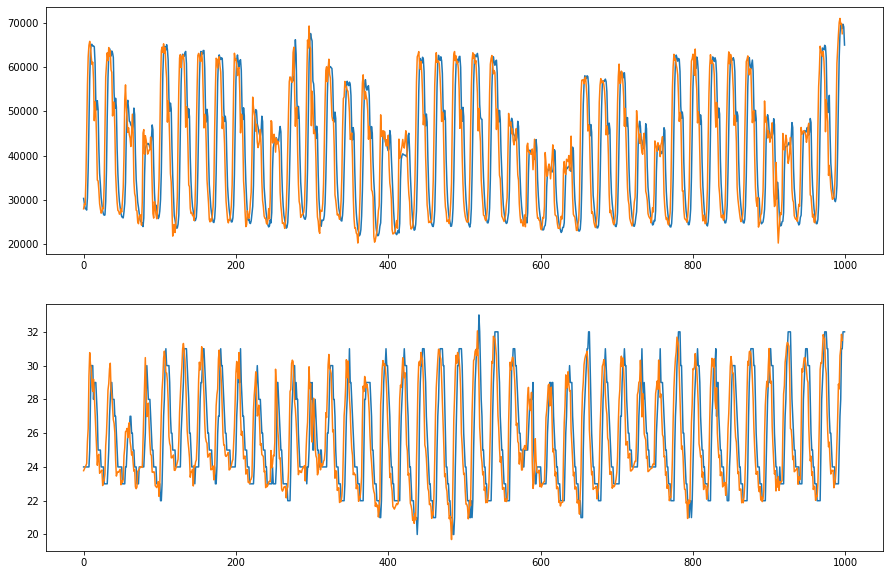

In [ ]:
predicted = model.predict(df, type='multivariate')
order=model.order
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,10])

ax[0].plot(df['load'].values)
ax[0].plot(predicted['load'].values)

ax[1].plot(df['temperature'].values)
ax[1].plot(predicted['temperature'].values)

In [ ]:
##Just for testing the method without cross validation
from pyFTS.benchmarks import Measures
columns=list(['temperature','load'])
result = {

         "rmse": [],
         "variable":[]
    }
final_result = {

         "rmse": [],
         "variable":[]
    }
for col in columns:
  original=df[col].values
  forecasted=predicted[col].values
  rmse = round(Measures.rmse(original,forecasted),3)
  result["rmse"].append(rmse)
  result["variable"].append(col)

measures = pd.DataFrame(result)

In [ ]:
import statistics
final_result = {
    "variable": [],
     "rmse": [],
}
var = measures.groupby("variable")

for col in columns:

    var_agr = var.get_group(col)

    rmse = round(statistics.mean(var_agr.loc[:,'rmse']),3)

    final_result["variable"].append(col)
    final_result["rmse"].append(rmse)



final = pd.DataFrame(final_result)
final

variable      rmse
0  temperature     0.419
1         load  1393.106

In [ ]:
from pyFTS.partitioners import Grid, Entropy

df=pd.read_csv('https://query.data.world/s/e5arbthdytod3m7wfcg7gmtluh3wa5', sep=';')
df=df[:8760]
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,10])

vload = Variable("load", data_label="load", partitioner=Grid.GridPartitioner, npart=3, data=df)
# vload.partitioner.plot(ax[0])

vtemperature = Variable("temperature", data_label="temperature", partitioner=Grid.GridPartitioner, npart=3, data=df)
# vtemperature.partitioner.plot(ax[1])


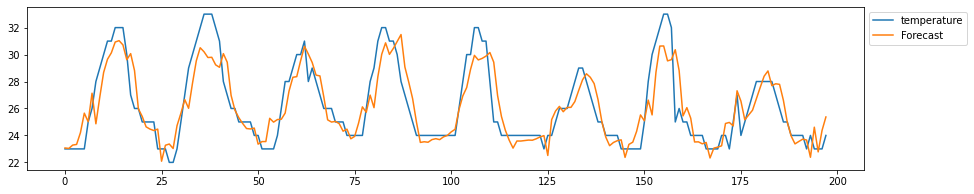

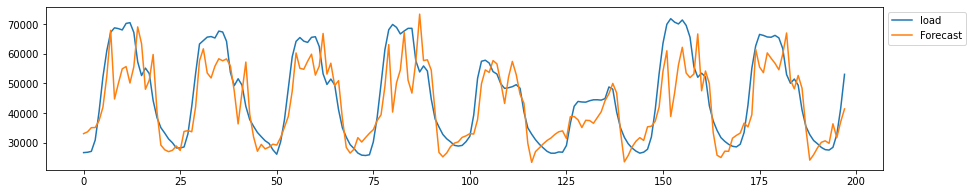

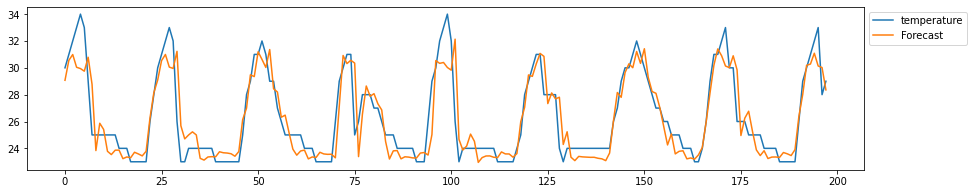

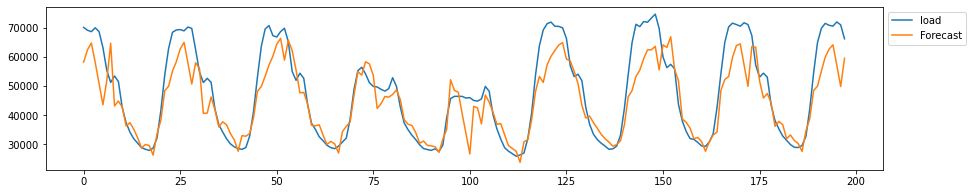

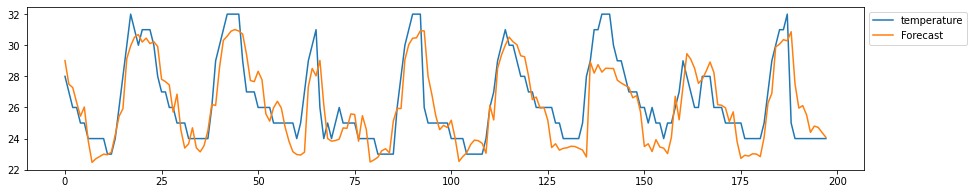

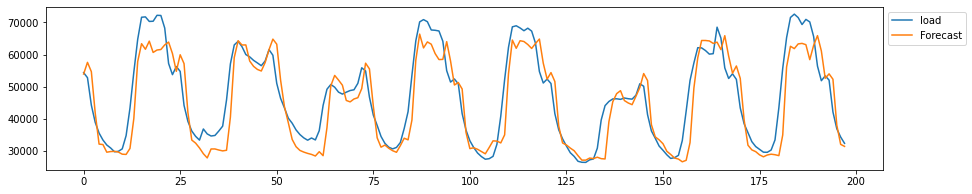

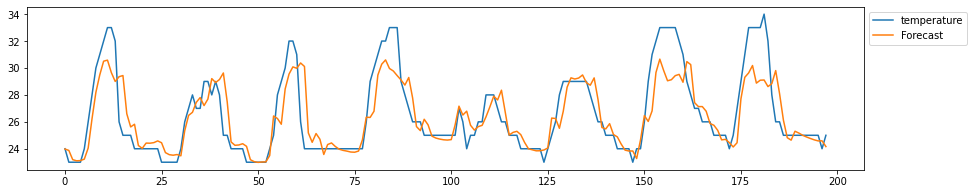

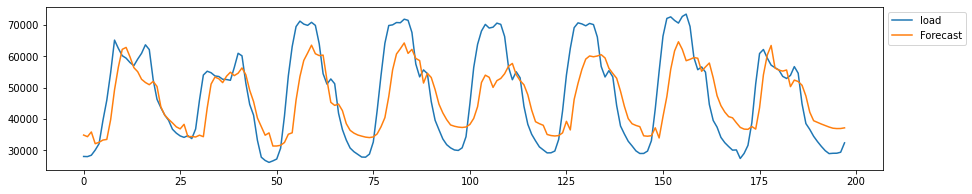

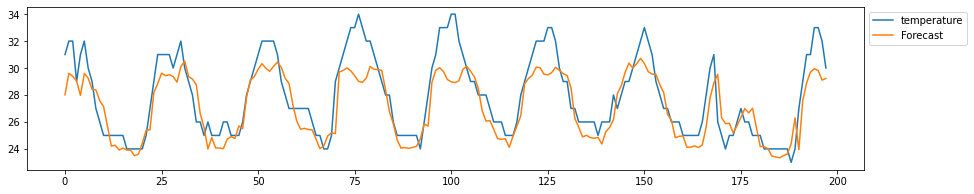

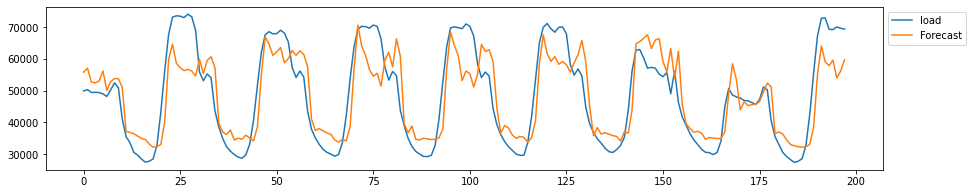

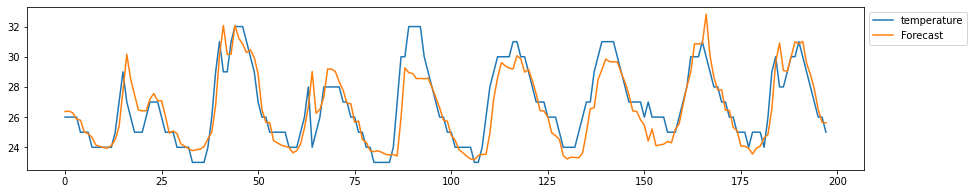

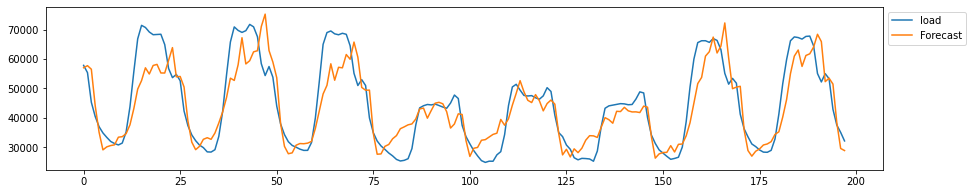

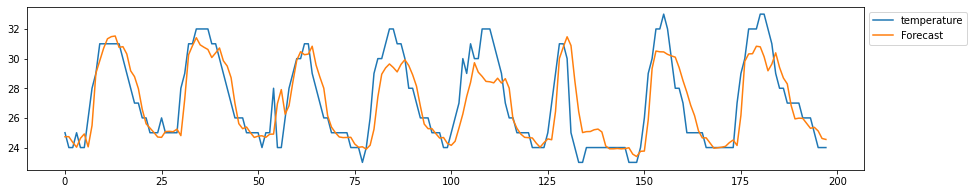

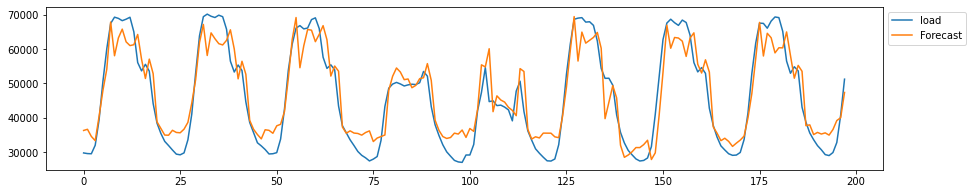

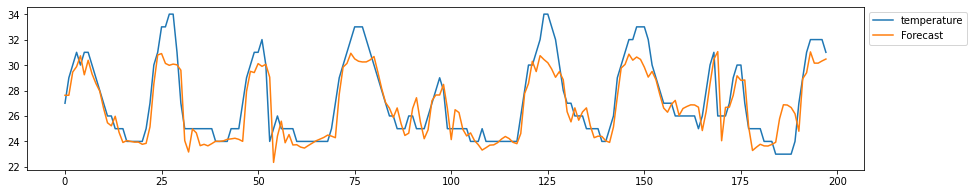

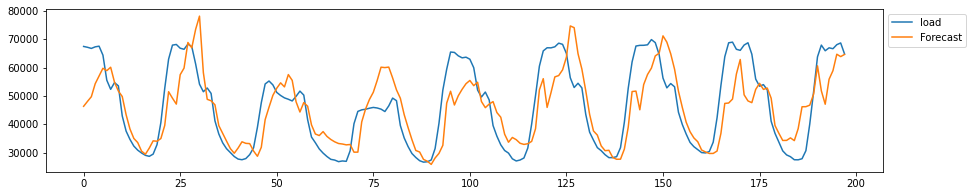

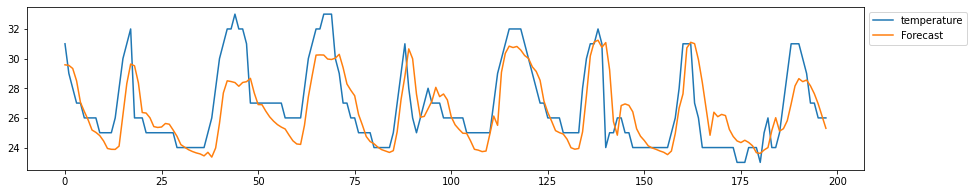

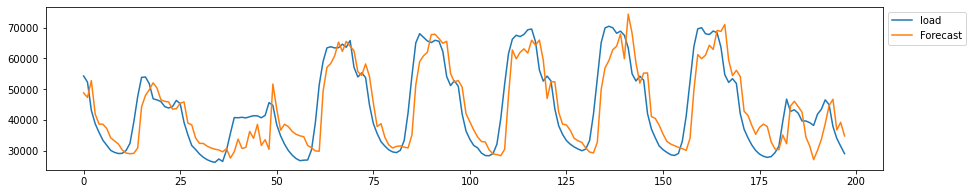

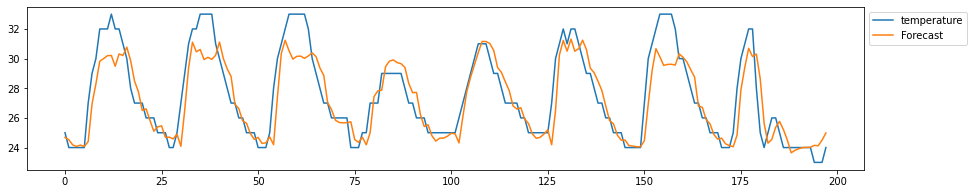

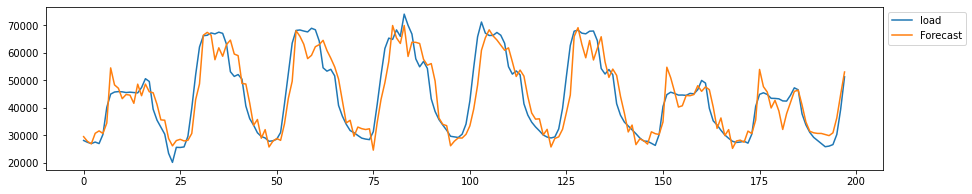

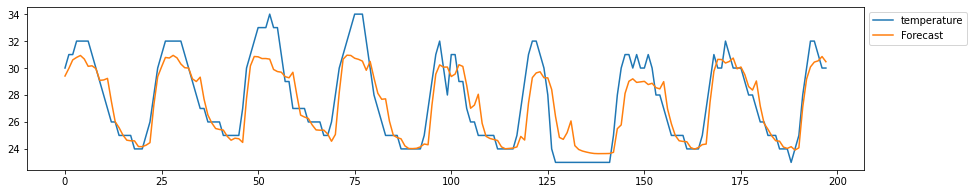

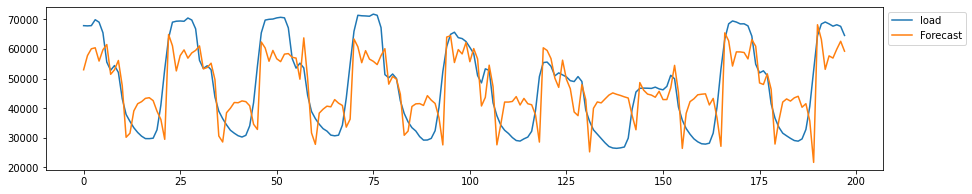

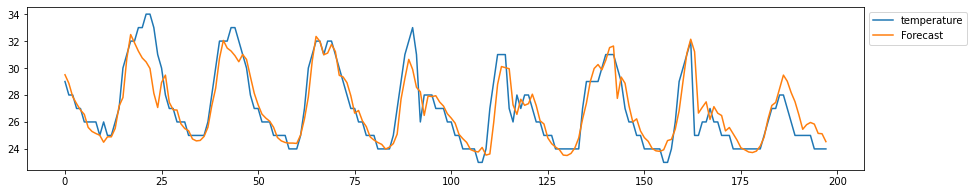

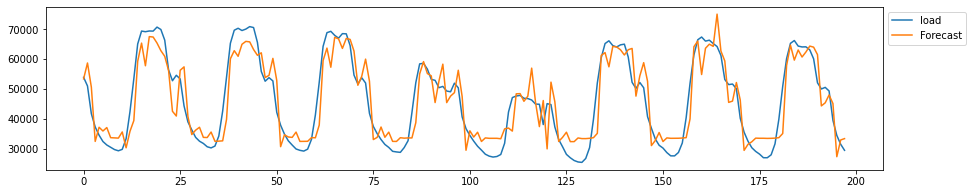

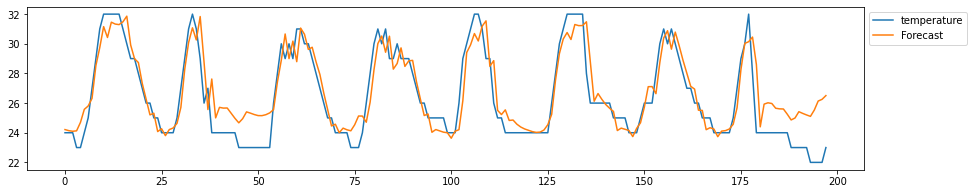

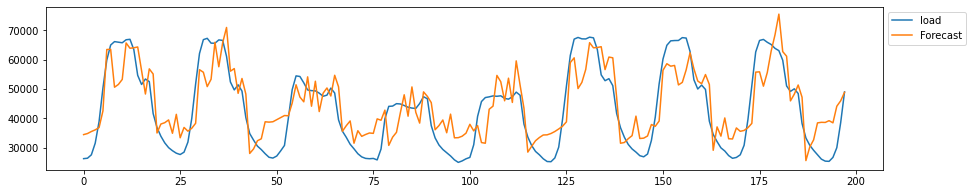

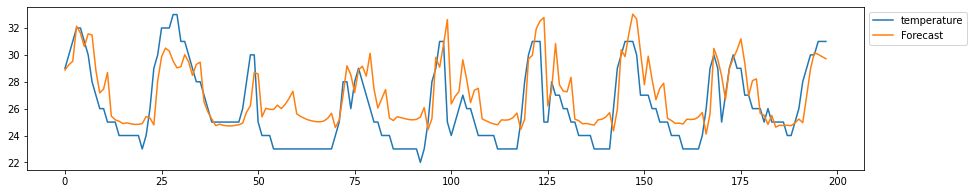

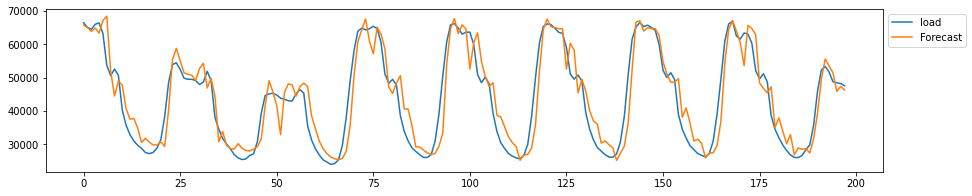

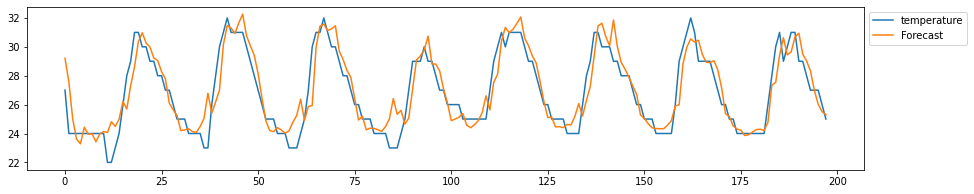

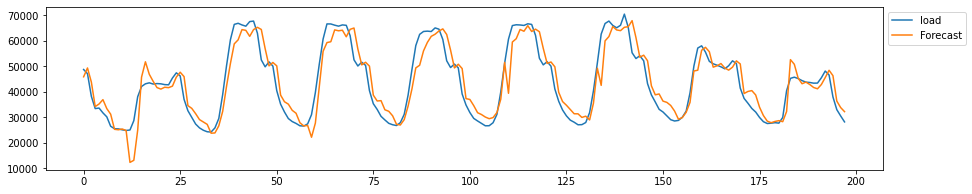

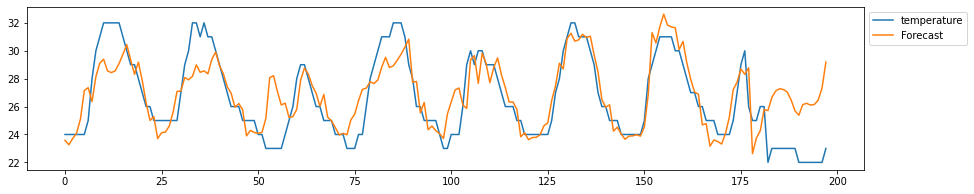

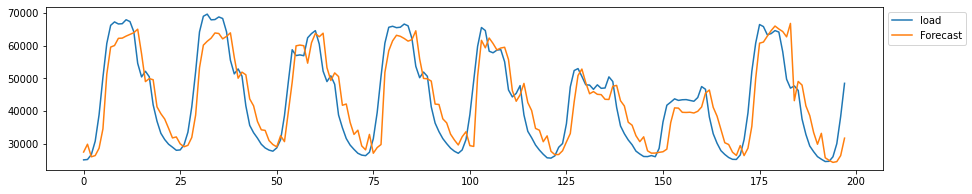

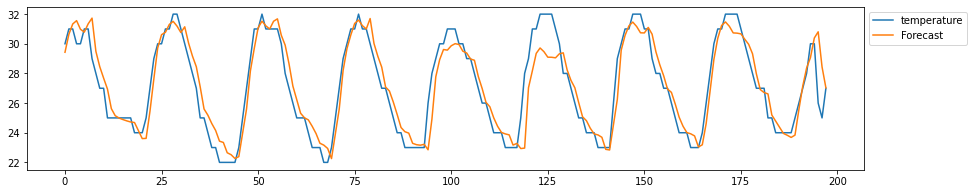

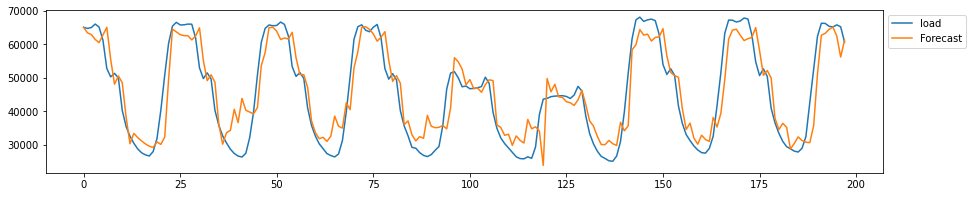

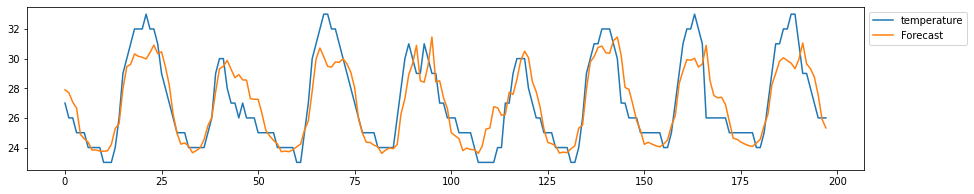

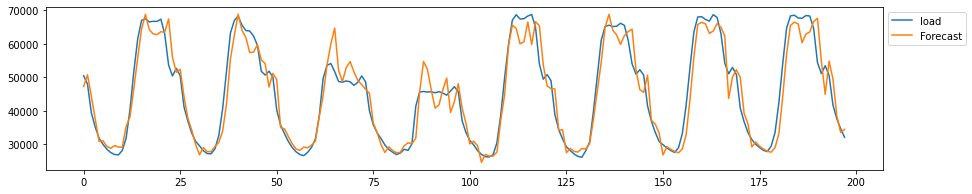

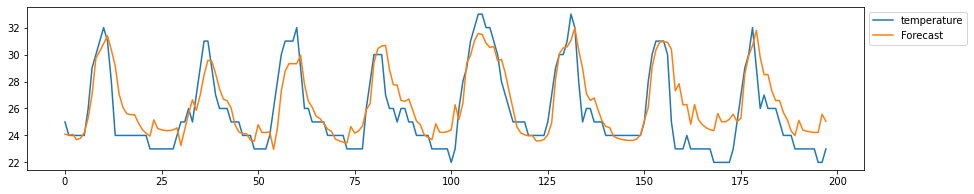

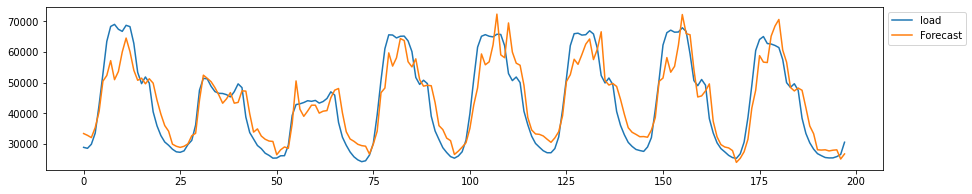

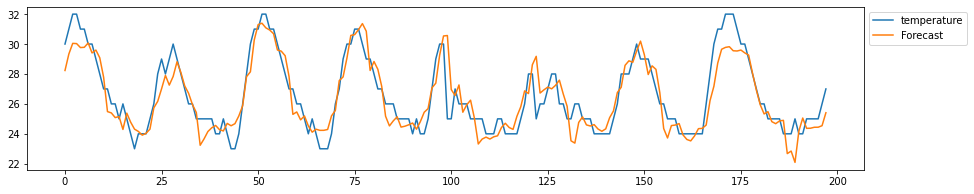

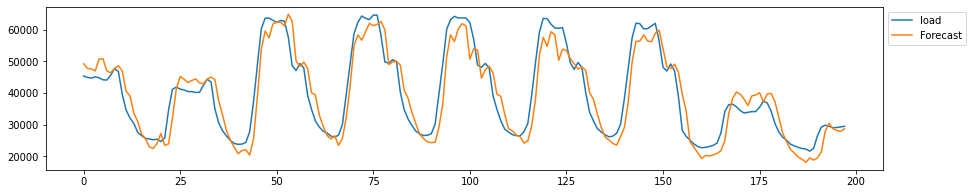

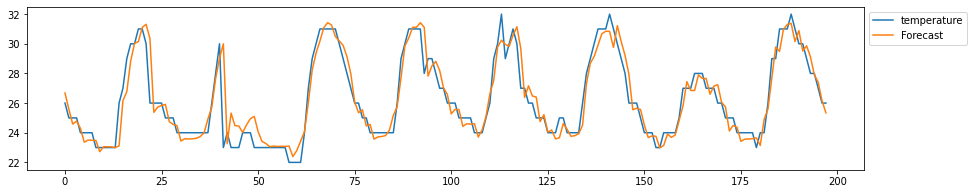

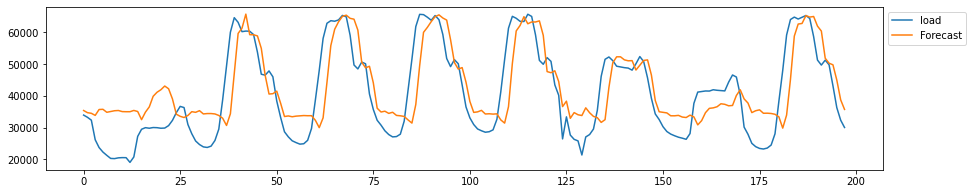

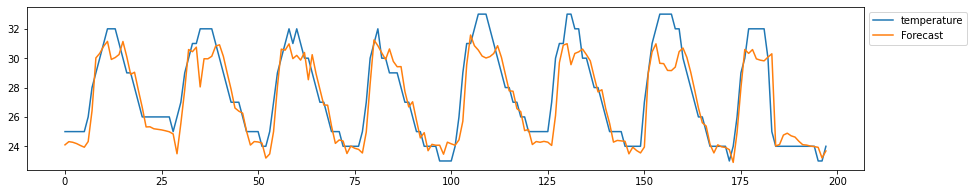

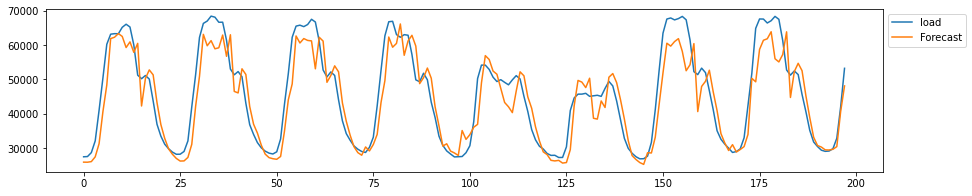

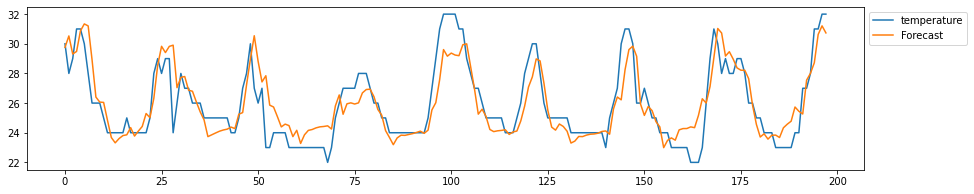

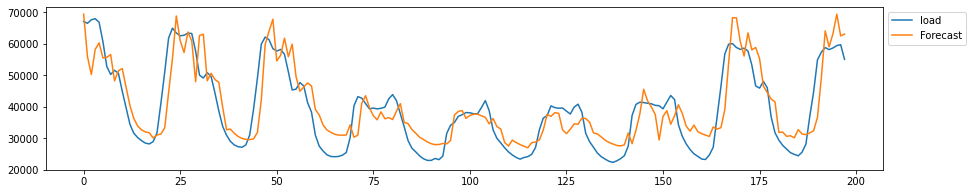

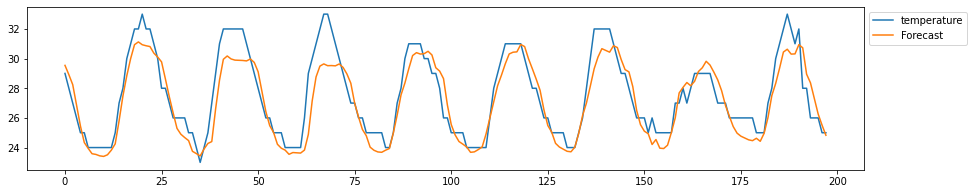

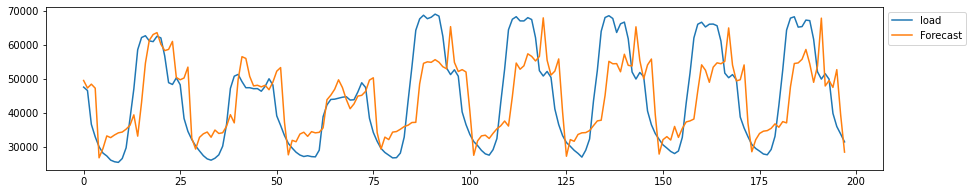

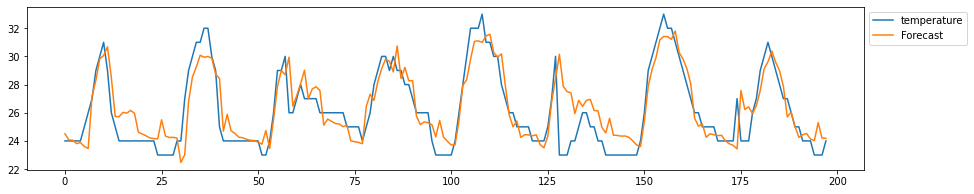

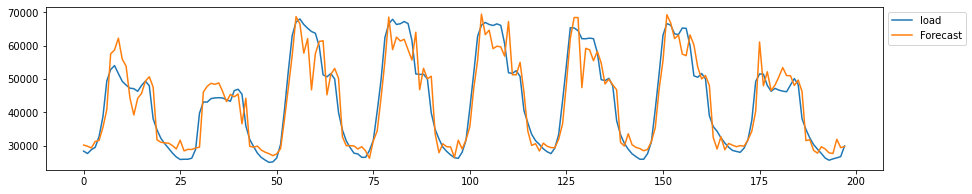

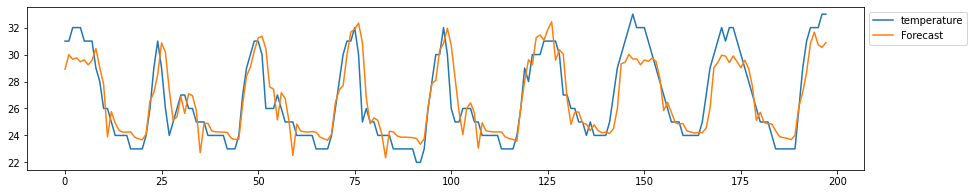

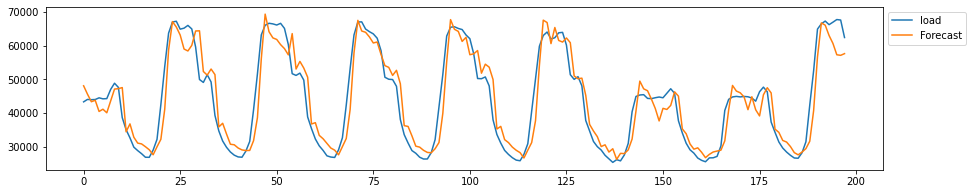

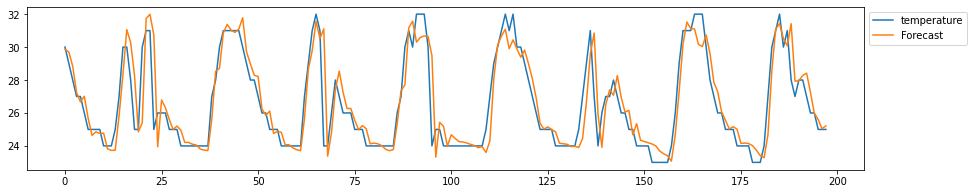

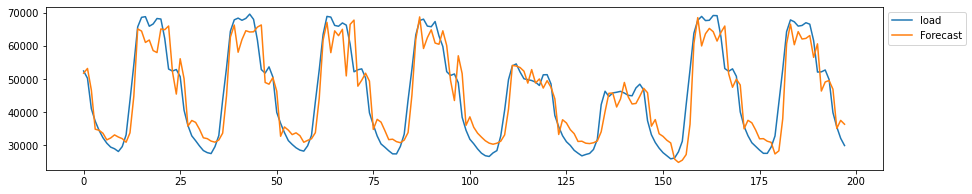

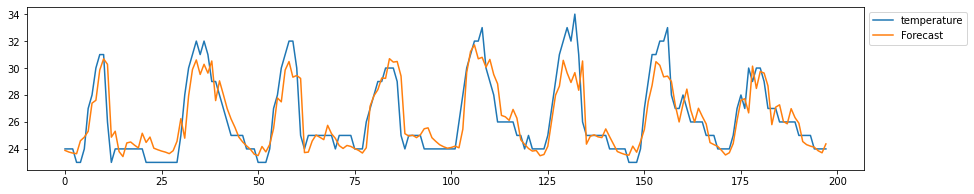

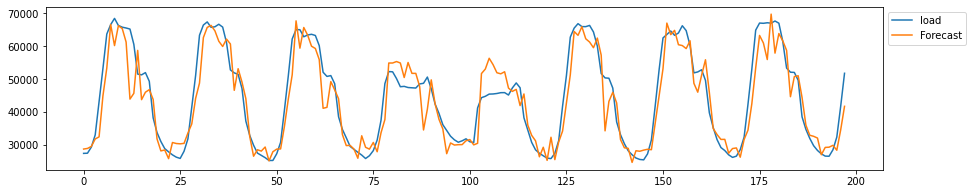

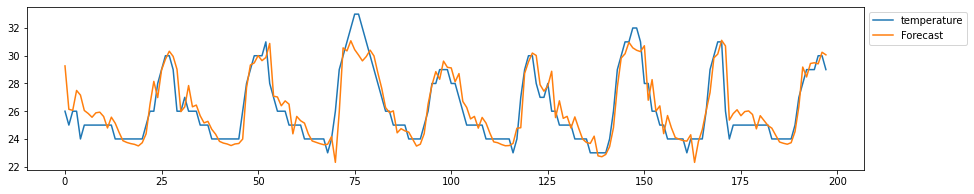

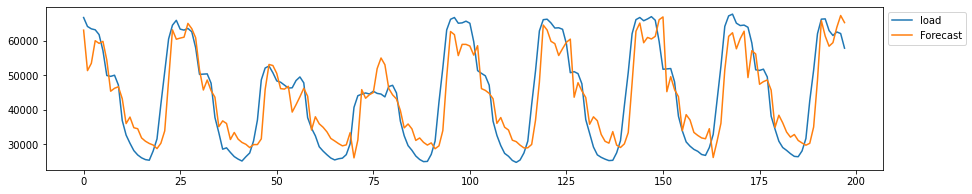

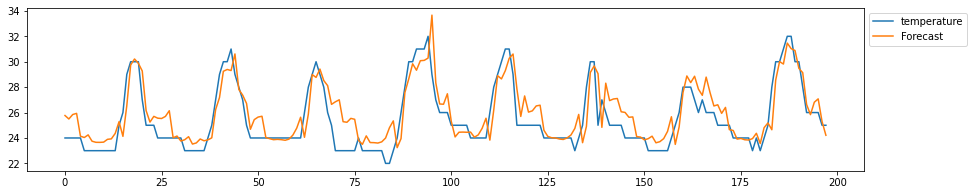

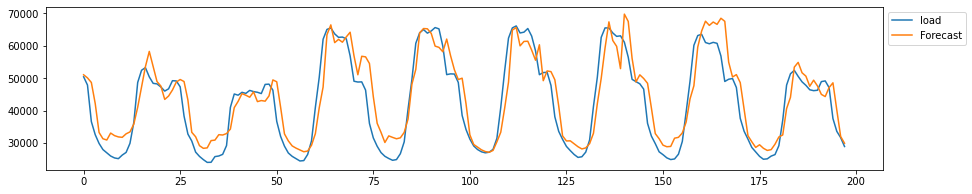

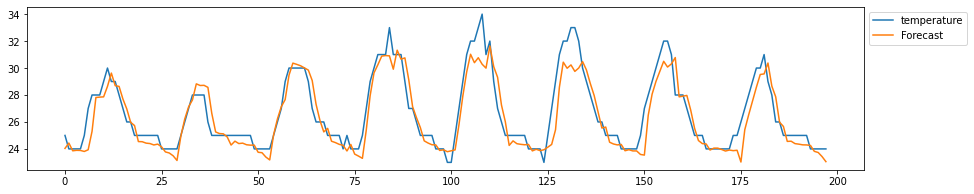

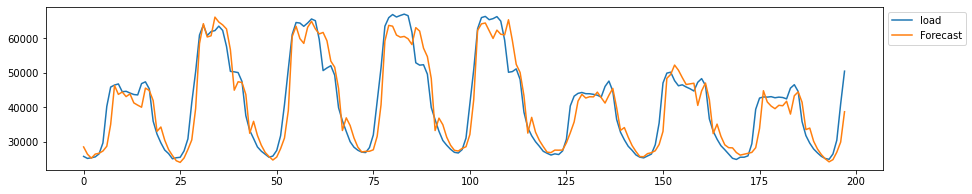

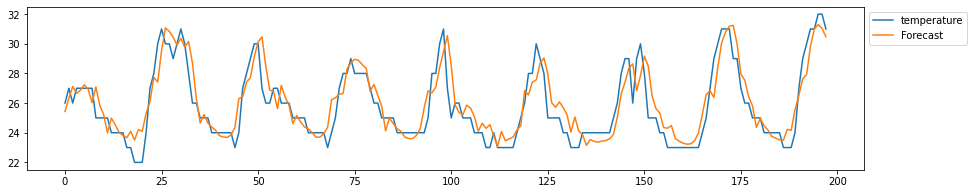

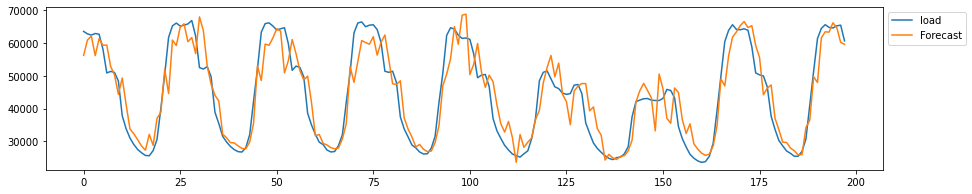

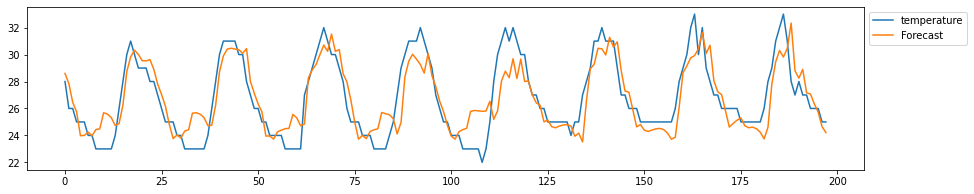

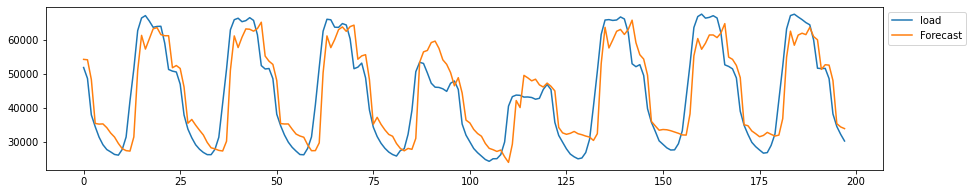

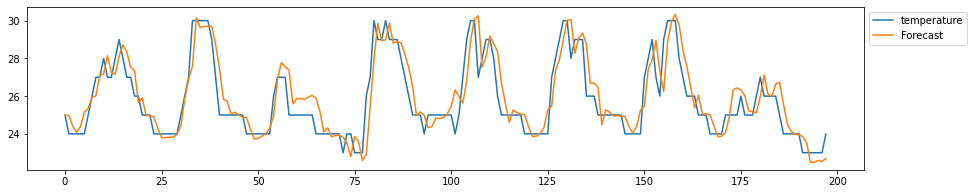

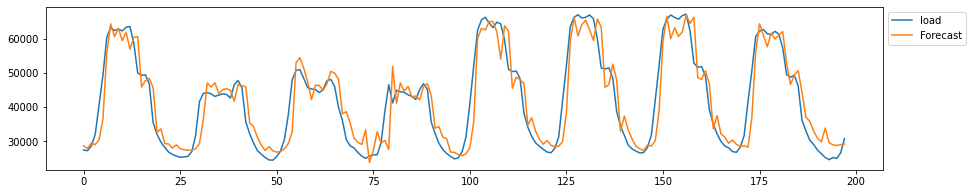

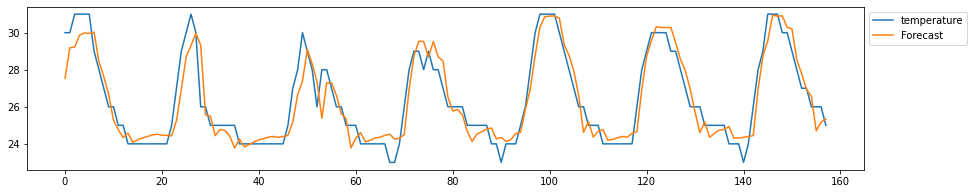

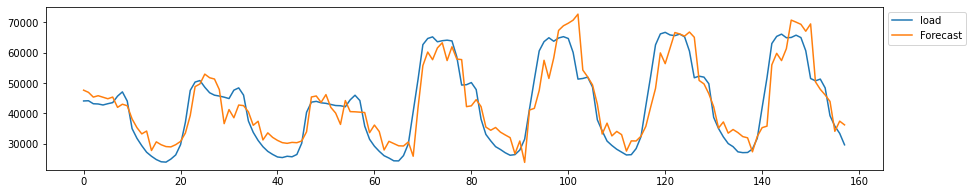

In [ ]:
import math
from pyFTS.benchmarks import Measures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from pyFTS.common import Util
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

'''Considering sliding window cross validation'''

result = {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "nrmse": [],
         "variable":[]
    }



for  ct,train, test in Util.sliding_window(data=df, windowsize=2000, train=0.9, increment_rate=0.2):
  model = Multivariate_FCM_FTS(order = 2, variables = [ vtemperature,vload],num_fcms=5)
  model.fit(train)
  predicted = model.predict(test, type='multivariate')
  df_forecats_columns=['temperature','load']
  columns=list(df_forecats_columns)

  for col in columns:
    order=model.order
    original = test[col][order:].values
    forecast = predicted[col].values
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
    ax.plot(original, label=col)
    ax.plot(forecast, label='Forecast')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
    plt.show()

    rmse = round(Measures.rmse(original,forecast),3)
    mae = round(mean_absolute_error(original,forecast),3)
    r2 = round(r2_score(original,forecast),3)
    mape = round(Measures.mape(original,forecast),3)
    nrmse = round(cal_nrmse(rmse, original),3)
    result["variable"].append(col)
    result["rmse"].append(rmse)
    result["nrmse"].append(nrmse)
    result["mape"].append(mape)
    result["mae"].append(mae)
    result["r2"].append(r2)
    result["window"].append(ct)

measures = pd.DataFrame(result)


In [ ]:
measures

window      rmse    mape       mae     r2  nrmse     variable
0        0     1.468   4.133     1.109  0.752  0.133  temperature
1        0  8621.944  14.074  6634.440  0.659  0.187         load
2      200     1.447   3.907     1.043  0.788  0.132  temperature
3      200  7506.319  10.458  5561.656  0.771  0.154         load
4      400     1.514   4.387     1.167  0.665  0.168  temperature
..     ...       ...     ...       ...    ...    ...          ...
65    6400  7074.316  13.540  5591.223  0.762  0.163         load
66    6600     0.983   2.774     0.721  0.752  0.140  temperature
67    6600  5438.739  10.223  4035.475  0.844  0.127         load
68    6800     0.888   2.564     0.684  0.860  0.111  temperature
69    6800  5868.410  11.713  4706.476  0.814  0.137         load

[70 rows x 7 columns]

In [ ]:
import statistics
#ttest = df.loc[:,:]

columns = list(df.loc[:,'temperature':'load'].columns)

final_result = {
    "variable": [],
    "rmse": [],
    "mae": [],
    "mape": [],
    "r2": [],
    "nrmse": [],
    "rmse_std": [],
    "mae_std": [],
    "mape_std": [],
    "r2_std": [],
    "nrmse_std": []
}


var = measures.groupby("variable")

for col in columns:

    var_agr = var.get_group(col)

    rmse = round(statistics.mean(var_agr.loc[:,'rmse']),3)
    mape = round(statistics.mean(var_agr.loc[:,'mape']),3)
    mae = round(statistics.mean(var_agr.loc[:,'mae']),3)
    r2 = round(statistics.mean(var_agr.loc[:,'r2']),3)
    nrmse = round(statistics.mean(var_agr.loc[:,'nrmse']),3)

    rmse_std = round(statistics.stdev(var_agr.loc[:,'rmse']),3)
    mape_std = round(statistics.stdev(var_agr.loc[:,'mape']),3)
    mae_std = round(statistics.stdev(var_agr.loc[:,'mae']),3)
    r2_std = round(statistics.stdev(var_agr.loc[:,'r2']),3)
    nrmse_std = round(statistics.stdev(var_agr.loc[:,'nrmse']),3)

    final_result["variable"].append(col)
    final_result["rmse"].append(rmse)
    final_result["mape"].append(mape)
    final_result["mae"].append(mae)
    final_result["r2"].append(r2)
    final_result["nrmse"].append(nrmse)

    final_result["rmse_std"].append(rmse_std)
    final_result["mape_std"].append(mape_std)
    final_result["mae_std"].append(mae_std)
    final_result["r2_std"].append(r2_std)
    final_result["nrmse_std"].append(nrmse_std)




final_measures= pd.DataFrame(final_result)

print("Statistics MIMO (test): ")
final_measures

Statistics MIMO (test): 


variable      rmse       mae    mape     r2  nrmse  rmse_std   mae_std  \
0  temperature     1.392     1.039   3.869  0.742  0.138     0.258     0.213   
1         load  6671.649  5254.854  12.384  0.770  0.150  1630.275  1394.394   

   mape_std  r2_std  nrmse_std  
0     0.837   0.087      0.022  
1     3.451   0.110      0.035